In [1]:
%run util.py

In [2]:
data_dir = '/home/jzh/Dropbox/Research/Anomaly_Detection/ROCHM/data_dir/'

In [3]:
N = 4
n = 50
beta_1 = 0.001
num_test_sample = 2000

In [4]:
# mu_0: the initial distribution; 1 x (N**2) 
# mu: the actual stationary distribution; 1 x (N**2)
# mu_1: the estimated stationary distribution 
# P: the new transition matrix (the old transition matrix is Q)
# G_1: the estimate of the gradient
# H_1: the estimate of the Hessian
# U_1: an estimated sample path of the Gaussian random vector U; length 1000

# P is the ground truth transition matrix
mu_0, mu, mu_1, P, G_1, H_1, U_1 = ChainGen(N)  

# PP is a different transition matrix for testing purposes
mu_0P, muP, mu_1P, PP, G_1P, H_1P, U_1P = ChainGen(N) 

zdump([N, mu_0, mu, mu_1, P, G_1, H_1, U_1, mu_0P, muP, mu_1P, PP, G_1P, H_1P, U_1P], \
      data_dir + 'P_PP_%d.pkz'%N)

<string>:372: RuntimeWarning: covariance is not positive-semidefinite.


In [5]:
N, mu_0, mu, mu_1, P, G_1, H_1, U_1, mu_0P, muP, mu_1P, PP, G_1P, H_1P, U_1P = zload(data_dir + 'P_PP_%d.pkz'%N)

In [6]:
mu

array([ 0.08935046,  0.04911288,  0.01594873,  0.08890404,  0.07898793,
        0.01472429,  0.01185376,  0.01607947,  0.01849938,  0.02976543,
        0.35538464,  0.03981101,  0.05647833,  0.02804285,  0.06027334,
        0.04678345])

In [7]:
muP

array([ 0.03090443,  0.02349001,  0.01904726,  0.05070081,  0.00605606,
        0.05437444,  0.08802051,  0.10698752,  0.04157328,  0.09537297,
        0.01353909,  0.04631011,  0.04560873,  0.08220111,  0.0761886 ,
        0.21962507])

In [8]:
eta_wc = {}
eta_Sanov = {}
negative_sample = {}
positive_sample = {}

# Get sample paths of the Markov chain with length n; 
# these paths will be the test set
for idx in range(int(num_test_sample/2)):
    negative_sample[idx] = chain(mu, P, n)
for idx in range(int(num_test_sample/2)):
    positive_sample[idx] = chain(muP, PP, n)
    
# Get thresholds for Hoeffding's test corresponding to sample length n    
key = str(n) + '_' + str(beta_1)
eta_1 = ThresWeakConv(N, beta_1, n, mu_0, mu, mu_1, P, G_1, H_1, U_1).ThresCal()
eta_2 = ThresSanov(N, beta_1, n, mu_0, mu, mu_1, P, G_1, H_1, U_1).ThresCal()
eta_wc[key] = eta_1
eta_Sanov[key] = eta_2

zdump([negative_sample, positive_sample, eta_wc, eta_Sanov], data_dir + 'testSample_threshold_%d.pkz'%N)

In [9]:
negative_sample, positive_sample, eta_wc, eta_Sanov = zload(data_dir + 'testSample_threshold_%d.pkz'%N)

In [10]:
len(negative_sample[0]), eta_wc, eta_Sanov

(50, {'50_0.001': 0.31153634260589796}, {'50_0.001': 0.13815510557964272})

In [11]:
from __future__ import division

mu = np.reshape(mu, (N, N))

key = str(n) + '_' + str(beta_1)

negative_sample_KL = {}
positive_sample_KL = {}

negative_sample_wc = {}
negative_sample_sv = {}

positive_sample_wc = {}
positive_sample_sv = {}

for idx in range(int(num_test_sample/2)):
    negative_sample_KL[idx] = KL_est(negative_sample[idx], mu)
    if negative_sample_KL[idx] > eta_wc[key]:
        negative_sample_wc[idx] = 1
    else:
        negative_sample_wc[idx] = -1
    if negative_sample_KL[idx] > eta_Sanov[key]:
        negative_sample_sv[idx] = 1
    else:
        negative_sample_sv[idx] = -1    
    
    
for idx in range(int(num_test_sample/2)):
    positive_sample_KL[idx] = KL_est(positive_sample[idx], mu)
    if positive_sample_KL[idx] > eta_wc[key]:
        positive_sample_wc[idx] = 1
    else:
        positive_sample_wc[idx] = -1
    if positive_sample_KL[idx] > eta_Sanov[key]:
        positive_sample_sv[idx] = 1
    else:
        positive_sample_sv[idx] = -1 

In [12]:
def count_one(x):
    s = 0
    for idx in range(len(x)):
        if x[idx] == 1:
            s += 1
    return s, len(x) - s

In [13]:
positive_sample_len_list = range(10, 1000, 10)

TPR_wc = []

for real_pos in positive_sample_len_list:
    x = [positive_sample_wc[idx] for idx in range(real_pos)]
    s, _ = count_one(x)
    TPR_wc.append(s / real_pos)
    
# TPR_wc.append(0)
# TPR_wc.append(1)

TPR_wc = list(set(TPR_wc))

TPR_wc.sort()
TPR_wc

[1.0]

In [14]:
negative_sample_len_list = range(10, 1000, 10)

FPR_wc = []

for real_neg in negative_sample_len_list:
    x = [negative_sample_wc[idx] for idx in range(real_neg)]
    s, _ = count_one(x)
    FPR_wc.append(s / real_neg)

# FPR_wc.append(0)
# FPR_wc.append(1)

FPR_wc = list(set(FPR_wc))

FPR_wc.sort()
FPR_wc

[0.0,
 0.00101010101010101,
 0.0010204081632653062,
 0.0010309278350515464,
 0.0010416666666666667,
 0.0010526315789473684,
 0.0010638297872340426,
 0.001075268817204301,
 0.0010869565217391304,
 0.001098901098901099,
 0.0011111111111111111,
 0.0011235955056179776,
 0.0011363636363636363,
 0.0011494252873563218,
 0.0011627906976744186,
 0.001176470588235294,
 0.0011904761904761906,
 0.0012048192771084338,
 0.0012195121951219512,
 0.0012345679012345679,
 0.00125,
 0.0012658227848101266,
 0.001282051282051282,
 0.0012987012987012987,
 0.0013157894736842105,
 0.0013333333333333333,
 0.0013513513513513514,
 0.0013698630136986301,
 0.001388888888888889,
 0.0014084507042253522,
 0.0014285714285714286,
 0.0014492753623188406,
 0.0014705882352941176,
 0.0014925373134328358,
 0.0015151515151515152,
 0.0015384615384615385,
 0.0015625,
 0.0015873015873015873,
 0.0016129032258064516,
 0.001639344262295082,
 0.0016666666666666668,
 0.001694915254237288,
 0.0017241379310344827,
 0.001754385964912280

In [15]:
range(100, 1100, 100)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

In [16]:
positive_sample_len_list = range(10, 1000, 10)

TPR_sv = []

for real_pos in positive_sample_len_list:
    x = [positive_sample_sv[idx] for idx in range(real_pos)]
    s, _ = count_one(x)
    TPR_sv.append(s / real_pos)

# TPR_sv.append(0)
# TPR_sv.append(1)

TPR_sv = list(set(TPR_sv))

TPR_sv.sort()
TPR_sv

[1.0]

In [17]:
negative_sample_len_list = range(10, 1000, 10)

FPR_sv = []

for real_neg in negative_sample_len_list:
    x = [negative_sample_sv[idx] for idx in range(real_neg)]
    s, _ = count_one(x)
    FPR_sv.append(s / real_neg)

# FPR_sv.append(0)
# FPR_sv.append(1)

FPR_sv = list(set(FPR_sv))

FPR_sv.sort()
FPR_sv

[0.4185185185185185,
 0.4188235294117647,
 0.41927710843373495,
 0.4195121951219512,
 0.42,
 0.42023809523809524,
 0.4205128205128205,
 0.42083333333333334,
 0.42142857142857143,
 0.4215189873417722,
 0.421875,
 0.42203389830508475,
 0.42205882352941176,
 0.4222222222222222,
 0.4225352112676056,
 0.42258064516129035,
 0.42295081967213116,
 0.42333333333333334,
 0.42337662337662335,
 0.42359550561797754,
 0.42363636363636364,
 0.4238636363636364,
 0.42388059701492536,
 0.42407407407407405,
 0.42417582417582417,
 0.42441860465116277,
 0.42446808510638295,
 0.42452830188679247,
 0.4245614035087719,
 0.4246153846153846,
 0.4246376811594203,
 0.4246575342465753,
 0.42473118279569894,
 0.425,
 0.42533333333333334,
 0.42567567567567566,
 0.4257142857142857,
 0.42586206896551726,
 0.4260869565217391,
 0.4263157894736842,
 0.4264367816091954,
 0.4268292682926829,
 0.42702702702702705,
 0.42745098039215684,
 0.428,
 0.42857142857142855,
 0.4287878787878788,
 0.42947368421052634,
 0.4297872340425

In [18]:
if len(TPR_sv) < len(FPR_sv):
    TPR_sv_ext = TPR_sv + [TPR_sv[-1]] * (len(FPR_sv) - len(TPR_sv))
else:
    TPR_sv_ext = TPR_sv[0:len(FPR_sv)]

In [19]:
if len(TPR_wc) < len(FPR_wc):
    TPR_wc_ext = TPR_wc + [TPR_wc[-1]] * (len(FPR_wc) - len(TPR_wc))
else:
    TPR_wc_ext = TPR_wc[0:len(FPR_wc)]

In [20]:
roc_sv_pts = [(s, t) for s, t in zip(FPR_sv, TPR_sv_ext)]

In [21]:
roc_wc_pts = [(s, t) for s, t in zip(FPR_wc, TPR_wc_ext)]

In [22]:
len(FPR_wc), len(TPR_wc_ext), len(roc_wc_pts)

(58, 58, 58)

In [23]:
roc_sv_pts, roc_wc_pts

([(0.4185185185185185, 1.0),
  (0.4188235294117647, 1.0),
  (0.41927710843373495, 1.0),
  (0.4195121951219512, 1.0),
  (0.42, 1.0),
  (0.42023809523809524, 1.0),
  (0.4205128205128205, 1.0),
  (0.42083333333333334, 1.0),
  (0.42142857142857143, 1.0),
  (0.4215189873417722, 1.0),
  (0.421875, 1.0),
  (0.42203389830508475, 1.0),
  (0.42205882352941176, 1.0),
  (0.4222222222222222, 1.0),
  (0.4225352112676056, 1.0),
  (0.42258064516129035, 1.0),
  (0.42295081967213116, 1.0),
  (0.42333333333333334, 1.0),
  (0.42337662337662335, 1.0),
  (0.42359550561797754, 1.0),
  (0.42363636363636364, 1.0),
  (0.4238636363636364, 1.0),
  (0.42388059701492536, 1.0),
  (0.42407407407407405, 1.0),
  (0.42417582417582417, 1.0),
  (0.42441860465116277, 1.0),
  (0.42446808510638295, 1.0),
  (0.42452830188679247, 1.0),
  (0.4245614035087719, 1.0),
  (0.4246153846153846, 1.0),
  (0.4246376811594203, 1.0),
  (0.4246575342465753, 1.0),
  (0.42473118279569894, 1.0),
  (0.425, 1.0),
  (0.42533333333333334, 1.0),
  

/home/jzh/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


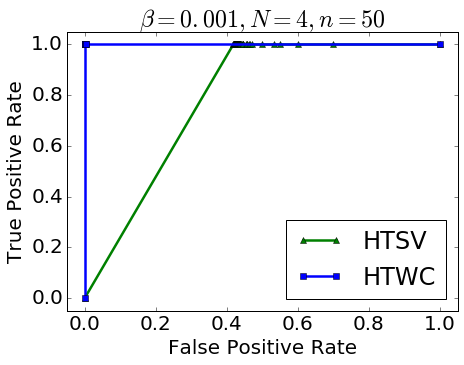

In [24]:
import matplotlib.pyplot as plt
import pylab
from pylab import *
%matplotlib inline  

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

plt.figure(figsize=(7, 5))

matplotlib.rc('font', **font)

roc_sv, = plt.plot([0] + [roc_sv_pts[idx][0] for idx in range(len(roc_sv_pts))] + [1], \
                   [0] + [roc_sv_pts[idx][1] for idx in range(len(roc_sv_pts))] + [1], "g-^", linewidth=2.5, \
                   markersize=6)
roc_wc, = plt.plot([0] + [roc_wc_pts[idx][0] for idx in range(len(roc_wc_pts))] + [1], \
                   [0] + [roc_wc_pts[idx][1] for idx in range(len(roc_wc_pts))] + [1], "b-s", linewidth=2.5, \
                  markersize=6)

plt.legend([roc_sv, roc_wc], [r"HTSV", r"HTWC"], loc=4)
plt.title(r"$\beta = %s, N = %s, n = %s$"%(beta_1, N, n))
# plt.xticks(N_list)

pylab.xlim(-0.05, 1.05)
pylab.ylim(-0.05, 1.05)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.grid()


savefig(data_dir + 'ROC_N_%s_n_%s.eps'%(N, n))

plt.show()